Analyzing responses:   0%|          | 0/1681 [00:00<?, ?it/s]

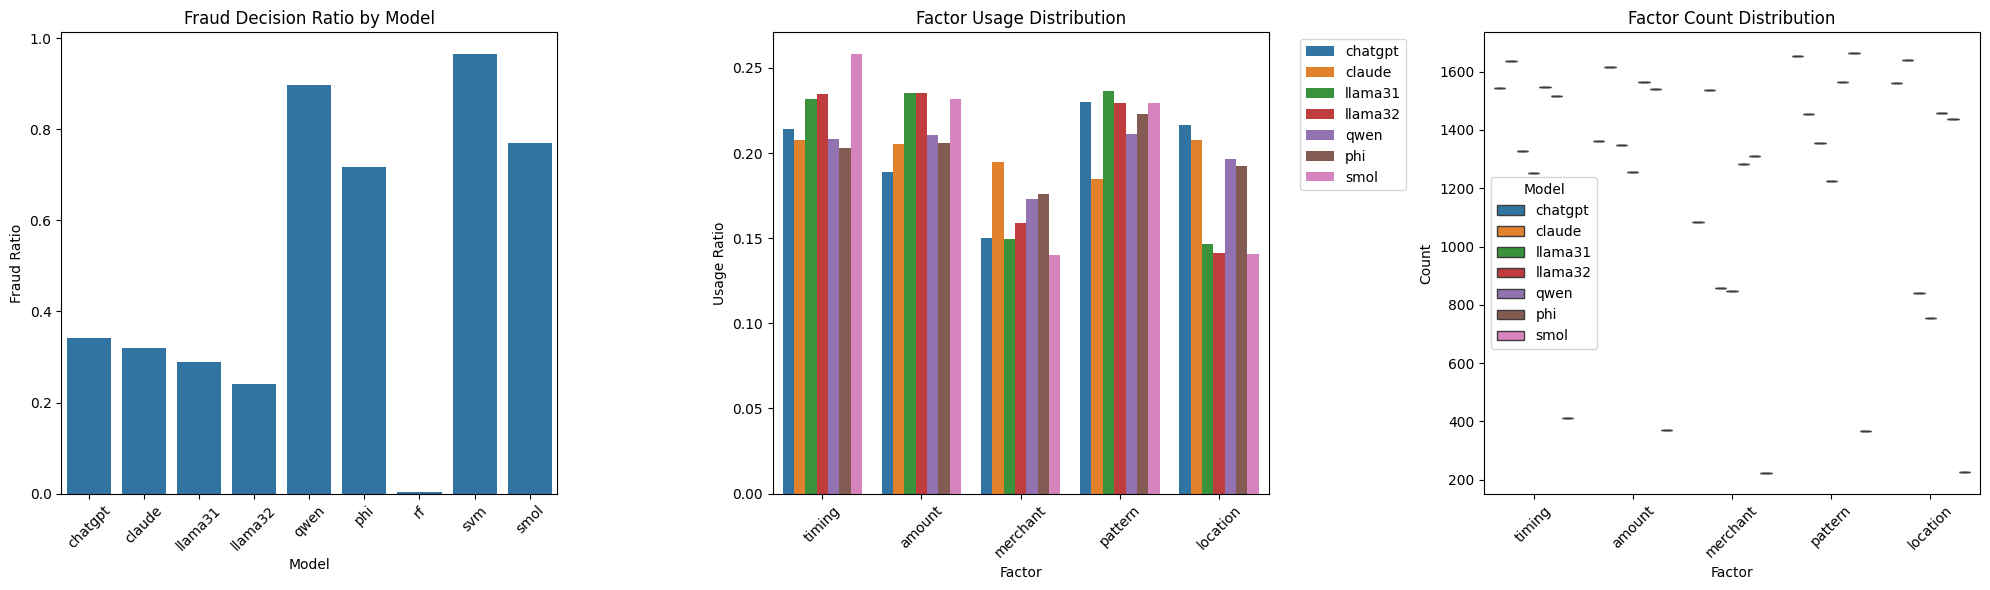

In [9]:
# First cell: Imports
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm.notebook import tqdm

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=['ner'])
# Add sentencizer if not present
if 'sentencizer' not in nlp.pipe_names:
    nlp.add_pipe('sentencizer')

def extract_conclusion(text):
    """Extract FRAUD/GENUINE conclusion from the text."""
    match = re.search(r'CONCLUSION:\s*(FRAUD|GENUINE)', text, re.IGNORECASE)
    return match.group(1) if match else None

def extract_key_factors(text):
    """Extract key factors mentioned in the reasoning."""
    factors = {
        'timing': ['time', 'hour', 'midnight', 'AM', 'PM'],
        'location': ['mile', 'location', 'distance', 'travel'],
        'amount': ['amount', 'purchase', '$', 'dollar'],
        'merchant': ['merchant', 'store', 'shop'],
        'pattern': ['pattern', 'typical', 'usual', 'common', 'regular']
    }
    
    doc = nlp(text)
    found_factors = defaultdict(list)
    
    for sent in doc.sents:
        sent_text = sent.text.lower()
        for factor, keywords in factors.items():
            if any(keyword.lower() in sent_text for keyword in keywords):
                found_factors[factor].append(sent.text)
    
    return dict(found_factors)

def analyze_reasoning(text):
    """Analyze the reasoning pattern in a response."""
    if not isinstance(text, str) or not text.strip():
        return None
        
    conclusion = extract_conclusion(text)
    factors = extract_key_factors(text)
    
    sentiment_analysis = {}
    doc = nlp(text)
    
    for factor, sentences in factors.items():
        sentiment = "neutral"
        for sent in sentences:
            sent_lower = sent.lower()
            negative_words = ['suspicious', 'unusual', 'odd', 'not', "doesn't", 'unlikely', 'red flag']
            positive_words = ['typical', 'common', 'usual', 'regular', 'reasonable', 'aligns', 'matches']
            
            if any(word in sent_lower for word in negative_words):
                sentiment = "negative"
                break
            elif any(word in sent_lower for word in positive_words):
                sentiment = "positive"
                break
                
        sentiment_analysis[factor] = sentiment
    
    return {
        'conclusion': conclusion,
        'factors_mentioned': list(factors.keys()),
        'factor_sentences': factors,
        'factor_sentiment': sentiment_analysis
    }

def process_row(args):
    """Process a single row of responses."""
    row, idx, model_columns = args
    row_analyses = {'transaction_id': idx}
    for col in model_columns:
        response = row[col]
        analysis = analyze_reasoning(response)
        if analysis:
            model_name = col.replace('_response', '')
            row_analyses[model_name] = analysis
    return row_analyses

def analyze_model_responses(df, n_jobs=None):
    """Analyze responses from each model using parallel processing."""
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
    
    model_columns = [col for col in df.columns if 'response' in col.lower()]
    
    # Prepare arguments for parallel processing
    row_args = [(row, idx, model_columns) for idx, row in df.iterrows()]
    
    # Use ProcessPoolExecutor for CPU-intensive tasks
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        all_analyses = list(tqdm(
            executor.map(process_row, row_args),
            total=len(row_args),
            desc="Analyzing responses"
        ))
    
    return all_analyses

def plot_analysis_results(analyses):
    """Plot the analysis results with multiple visualizations."""
    # Prepare data
    model_stats = defaultdict(lambda: {
        'fraud_count': 0,
        'genuine_count': 0,
        'factors': defaultdict(int),
        'sentiments': defaultdict(lambda: defaultdict(int))
    })
    
    for analysis in analyses:
        for model, results in analysis.items():
            if model == 'transaction_id':
                continue
                
            if results['conclusion'] == 'FRAUD':
                model_stats[model]['fraud_count'] += 1
            elif results['conclusion'] == 'GENUINE':
                model_stats[model]['genuine_count'] += 1
            
            for factor in results['factors_mentioned']:
                model_stats[model]['factors'][factor] += 1
            
            for factor, sentiment in results['factor_sentiment'].items():
                model_stats[model]['sentiments'][factor][sentiment] += 1

    # Create figure with subplots in a 1x3 layout
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Decision Distribution
    plt.subplot(1, 3, 1)
    decision_data = []
    for model, stats in model_stats.items():
        total = stats['fraud_count'] + stats['genuine_count']
        if total > 0:
            fraud_ratio = stats['fraud_count'] / total
            decision_data.append({'Model': model, 'Fraud Ratio': fraud_ratio})
    
    decision_df = pd.DataFrame(decision_data)
    sns.barplot(data=decision_df, x='Model', y='Fraud Ratio')
    plt.title('Fraud Decision Ratio by Model')
    plt.xticks(rotation=45)
    
    # 2. Factor Usage Distribution
    plt.subplot(1, 3, 2)
    factor_data = []
    for model, stats in model_stats.items():
        total_factors = sum(stats['factors'].values())
        if total_factors > 0:
            for factor, count in stats['factors'].items():
                factor_data.append({
                    'Model': model,
                    'Factor': factor,
                    'Usage Ratio': count / total_factors
                })
    
    factor_df = pd.DataFrame(factor_data)
    sns.barplot(data=factor_df, x='Factor', y='Usage Ratio', hue='Model')
    plt.title('Factor Usage Distribution')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Factor Count Distribution
    plt.subplot(1, 3, 3)
    count_data = []
    for model, stats in model_stats.items():
        for factor, count in stats['factors'].items():
            count_data.append({
                'Model': model,
                'Factor': factor,
                'Count': count
            })
    
    count_df = pd.DataFrame(count_data)
    sns.boxplot(data=count_df, x='Factor', y='Count', hue='Model')
    plt.title('Factor Count Distribution')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return model_stats

# Main analysis function
def analyze_fraud_reasoning(file_path):
    """Run the complete analysis and show results."""
    # Load data
    df = pd.read_csv(file_path, sep=';')
    
    # Run analysis
    analyses = analyze_model_responses(df)
    
    # Plot results
    stats = plot_analysis_results(analyses)
    
    return analyses, stats

# Usage example:
# FILE_PATH = '/home/hessel/code/master-thesis/src/results/final/final_dataset2.ssv'
# analyses, stats = analyze_fraud_reasoning(FILE_PATH)

# Usage example:
FILE_PATH = '/home/hessel/code/master-thesis/src/results/final/final_dataset.ssv'
analyses, stats = analyze_fraud_reasoning(FILE_PATH)